# Economische welvaart en productiviteit beïnvloeden uitstoot

Hogere economische welvaart gaat vaak gepaard met betere technologieën, schaalvoordelen en geavanceerde productiesystemen. Daardoor kunnen rijkere landen meer output genereren met minder inzet van grondstoffen en energie, wat resulteert in een lagere CO₂-uitstoot per ton geproduceerd voedsel. Deze benadering onderzoekt hoe economische middelen en efficiëntie samen emissiereductie mogelijk maken.

Binnen dit perspectief onderscheiden we twee kernargumenten:

- Rijke landen produceren efficiënter en stoten minder CO₂ uit per ton voedsel
- Hogere productie-efficiëntie verlaagt uitstoot ongeacht de productieschaal  
 


### Rijke landen produceren efficiënter en stoten minder CO₂ uit per ton voedsel

Door de industrialisering en technologische vooruitgang beschikken rijkere landen doorgaans over meer kapitaal voor moderne landbouwmachines, precisielandbouw en efficiënte logistiek. We koppelen het bruto binnenlands product (BBP) per hoofd aan de CO₂-uitstoot per ton geproduceerd voedsel om te zien of die toegang aan écht schonere productie bijdraagt.

Historisch gezien leidde meer investeringsruimte in onderzoek & ontwikkeling tot innovatie in teeltmethoden en gewasbescherming. Zo kunnen boeren in welvarende economieën met minder meststoffen, water en land hogere opbrengsten halen, waardoor de emissie-intensiteit daalt.

Dus als welvaart gelijkstaat aan toegang tot betere technologie en schaalvoordeel, verwachten we een dalende CO₂-uitstoot per ton voedsel naarmate het BBP per hoofd stijgt.


In [7]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import HTML, display

# Renderer voor inline weergave
pio.renderers.default = 'notebook'  # of 'jupyterlab'

# ——————————————————————————————
# 1) DATA INLADEN & SAMENSTELLEN
# ——————————————————————————————
emissions_df  = pd.read_csv('Emissions_Agriculture_Energy_E_All_Data.csv', encoding='latin1')
production_df = pd.read_csv('Production_Crops_Livestock_E_All_Data.csv', encoding='latin1', low_memory=False)
gdp_df        = pd.read_csv('gdp-per-capita-worldbank.csv')
co2_df        = pd.read_csv('owid-co2-data.csv')

# CO₂ 2021 per land (kt)
em2021 = (
    emissions_df
    .query("Item=='Total Energy' and Element=='Emissions (CO2)' and Unit=='kt'")
    [['Area','Y2021']]
    .rename(columns={'Area':'Land','Y2021':'CO2_uitstoot_kt'})
)
em2021['CO2_uitstoot_kt'] = pd.to_numeric(em2021['CO2_uitstoot_kt'], errors='coerce')

# Landbouwproductie 2021 (t → ton)
prod2021 = (
    production_df
    .query("Element=='Production' and Unit=='t'")
    .groupby('Area')['Y2021'].sum()
    .reset_index()
    .rename(columns={'Area':'Land','Y2021':'Productie_ton'})
)
prod2021['Productie_ton'] = pd.to_numeric(prod2021['Productie_ton'], errors='coerce')

# BBP per hoofd 2021
gdp2021 = (
    gdp_df
    .query("Year==2021")
    .rename(columns={
        'Entity':'Land',
        'GDP per capita, PPP (constant 2021 international $)':'BBP_per_hoofd'
    })[['Land','BBP_per_hoofd']]
)
gdp2021['BBP_per_hoofd'] = pd.to_numeric(gdp2021['BBP_per_hoofd'], errors='coerce')

# Bevolking 2021
pop2021 = (
    co2_df
    .query("year==2021")
    [['country','population']]
    .rename(columns={'country':'Land','population':'Bevolking'})
)
pop2021['Bevolking'] = pd.to_numeric(pop2021['Bevolking'], errors='coerce')

# Merge & bereken CO2_per_ton
df = (
    em2021
    .merge(prod2021,  on='Land')
    .assign(
        CO2_per_ton=lambda d: d['CO2_uitstoot_kt']*1000/d['Productie_ton']
    )
    .merge(gdp2021,    on='Land')
    .merge(pop2021,    on='Land')
    .dropna()
)

# Selectie en vertaling
landen_map = {
    'Brazil':'Brazilië','India':'India','Indonesia':'Indonesië',
    'Japan':'Japan','Nigeria':'Nigeria','South Africa':'Zuid-Afrika',
    'United States':'Verenigde Staten'
}
df_sel = df[df['Land'].isin(landen_map)].copy()
df_sel['land_naam'] = df_sel['Land'].map(landen_map)

# Normaliseren
cols = ['BBP_per_hoofd','CO2_per_ton','Productie_ton','Bevolking']
df_norm = df_sel.copy()
for c in cols:
    mn, mx = df_norm[c].min(), df_norm[c].max()
    df_norm[c] = (df_norm[c]-mn)/(mx-mn)

# ——————————————————————————————
# 2) INTERACTIEVE RADAR CHART MET PLOTLY
# ——————————————————————————————
categories = cols
fig = go.Figure()

# Voeg per land één polar-plot
for i, row in df_norm.iterrows():
    vals = row[categories].tolist()
    vals += vals[:1]  # sluit de cirkel
    fig.add_trace(go.Scatterpolar(
        r=vals,
        theta=categories + [categories[0]],
        fill='toself',
        name=row['land_naam'],
        hovertemplate='<b>%{text}</b><br>' +
                      '%{theta}: %{r:.2f}<extra></extra>',
        text=[row['land_naam']]*len(vals)
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0,1],
            tickvals=[0,0.25,0.5,0.75,1]
        )
    ),
    title='Internationale vergelijking: BBP, uitstoot & landbouwproductie (genormaliseerd)',
    showlegend=True,
    legend=dict(title='Land')
)

# ——————————————————————————————
# 3) INLINE RENDEREN ZONDER HTML/JS TE TONEN
# ——————————————————————————————
html_snippet = fig.to_html(include_plotlyjs='cdn', full_html=False)
display(HTML(html_snippet))


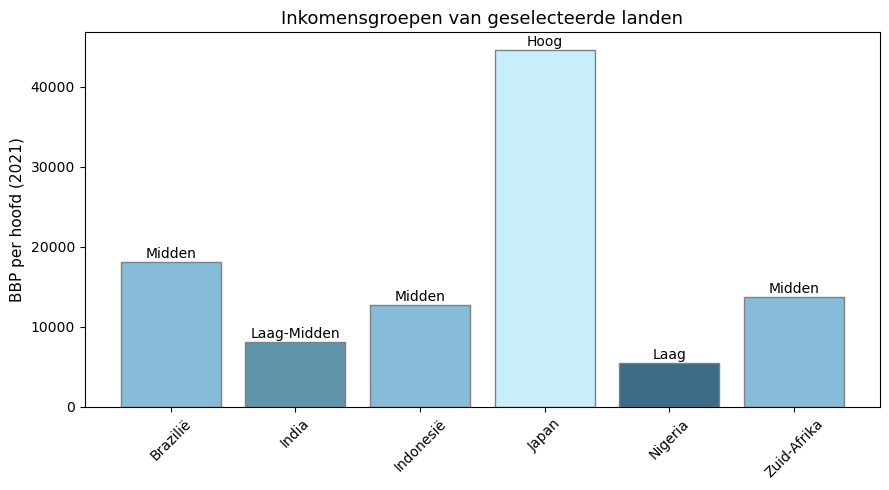

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

gdp_df = pd.read_csv('gdp-per-capita-worldbank.csv')

gdp_2021 = gdp_df[gdp_df['Year'] == 2021][['Entity', 'GDP per capita, PPP (constant 2021 international $)']]
gdp_2021.columns = ['Land_eng', 'BBP_per_hoofd']
gdp_2021 = gdp_2021.dropna()

def bepaal_inkomensgroep(bbp):
    if bbp < 6000:
        return 'Laag'
    elif bbp < 10000:
        return 'Laag-Midden'
    elif bbp < 20000:
        return 'Midden'
    elif bbp < 40000:
        return 'Hoog-Midden'
    else:
        return 'Hoog'

gdp_2021['Inkomensgroep'] = gdp_2021['BBP_per_hoofd'].apply(bepaal_inkomensgroep)

vertaling_landen = {
    'India': 'India',
    'Japan': 'Japan',
    'Brazil': 'Brazilië',
    'South Africa': 'Zuid-Afrika',
    'Indonesia': 'Indonesië',
    'Nigeria': 'Nigeria'
}

landen_eng = list(vertaling_landen.keys())
gdp_2021 = gdp_2021[gdp_2021['Land_eng'].isin(landen_eng)].copy()
gdp_2021['Land'] = gdp_2021['Land_eng'].map(vertaling_landen)

kleuren = {
    'Laag': '#3B6C87',
    'Laag-Midden': '#6094AA',
    'Midden': '#87BCD9',
    'Hoog-Midden': '#A3D8F4',
    'Hoog': '#C7EEF9'
}
bar_kleuren = [kleuren[groep] for groep in gdp_2021['Inkomensgroep']]

plt.figure(figsize=(9, 5))
balken = plt.bar(gdp_2021['Land'], gdp_2021['BBP_per_hoofd'], color=bar_kleuren, edgecolor='gray')

for balk, groep in zip(balken, gdp_2021['Inkomensgroep']):
    plt.text(balk.get_x() + balk.get_width()/2, balk.get_height() + 500,
             groep, ha='center', fontsize=10, color='black')

plt.ylabel('BBP per hoofd (2021)', fontsize=11)
plt.title('Inkomensgroepen van geselecteerde landen', fontsize=13)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Waarom deze landen?

De geselecteerde landen (India, Japan, Brazilië, Zuid-Afrika, Indonesië en Nigeria) zijn gekozen om twee redenen. Ten eerste vertegenwoordigen ze verschillende inkomensgroepen, van laag (Nigeria) tot hoog (Japan), wat het mogelijk maakt om de relatie tussen economische welvaart en efficiëntie in voedselproductie te onderzoeken. Ten tweede verschillen ze sterk in CO₂-uitstoot per ton voedsel en productiviteit. Hierdoor kunnen zowel algemene trends als opvallende afwijkingen goed zichtbaar worden gemaakt.


##### Analyse: Economische rijkdom versus CO₂-intensiteit

India – Laag BBP, lage emissie-intensiteit </br>
India heeft met ongeveer \$2 500 BBP per hoofd het laagste welvaartsniveau in de vergelijking, maar de radardiagram plaatst het dicht bij de binnenrand op de CO₂-per-ton-as. Traditionele irrigatie, lage kunstmesttoepassing en grootschalige, arbeidsintensieve rijst- en tarweteelt drukken de emissie-intensiteit. Grote productievolumes (hoge positie op de productie-as) en de enorme bevolking (volgens de bevolking-as) benadrukken dat lage technologieniveaus niet per se leiden tot vervuilende landbouw.

Japan – Hoog BBP, hoge emissie-intensiteit  </br>
Met ruim \$40 000 BBP per hoofd voert Japan de welvaartslijst aan, maar scoort ook extreem hoog op de CO₂-per-ton-as. Krappe akkergrond en intensieve kassen-, veeteelt- en importafhankelijke voederketens dwingen tot veel kunstlicht, warmte en transport. Daardoor schuift het radardiagram Japan ver naar de rand op de emissie-as, ondanks lage productievolumes en een beperkte landbouwbevolking.

Brazilië – Gemiddeld BBP, middelhoog emissieniveau </br>
Brazilië combineert een BBP rond \$9 000 met een relatief bescheiden CO₂-per-ton-score in het radardiagram. De afwezigheid van vorst en het ontbreken van kassen verlagen de productiekosten, terwijl grootschalige soja- en vleesproductie efficiënte opbrengsten biedt. Ontbossing voor landbouwgrond brengt wel extra CO₂-uitstoot buiten de kassen om, wat de emissiepositie iets omhoog haalt.

Zuid-Afrika – Middeninkomen en gemiddelde emissie  </br>
Zuid-Afrika draait op zo’n \$6 000 BBP per hoofd en ligt in het midden van alle assen. De balans tussen exportgerichte fruit- en wijnbouw, kleinschalige maïsteelt en matige modernisering resulteert in gemiddelde CO₂-per-ton-waarden. Het radardiagram toont een nagenoeg symmetrisch profiel: geen uitschieters naar boven of onder.

Indonesië – Groeiend BBP, matige efficiëntie</br>
Met circa \$4 000 BBP per hoofd scoort Indonesië iets hoger dan India, maar de CO₂-per-ton-as blijft middelhoog. Plantaardige oliegewassen en kleinschalige palmolieplantages leveren gematigde productievolumes en emissies. Technologische adoptie blijft beperkt, wat zich vertaalt in een gelijkmatig maar niet uitzonderlijk radardiagram.

Nigeria – Laag BBP, lage productie en emissie</br>
Nigeria rondt de lijst af met ongeveer \$2 400 BBP per hoofd en scoort laag op alle assen. De geringe mechanisatie en kleinschalige rijst- en maniokteelt beperken zowel productie- als emissiecijfers. De lage CO₂-per-ton-waarde volgt vooral uit de kleine volumes, waardoor de echte efficiëntie moeilijk te beoordelen is.


### Productie-efficiëntie zorgt voor minder uitstoot per ton voedsel

Met deze visualisatie onderzoeken we of landen die efficiënter produceren (meer voedsel per hectare) ook minder CO₂ uitstoten per geproduceerde ton. De verwachting is dat hogere efficiëntie leidt tot minder uitstoot en dus duurzamere voedselproductie.

In [3]:
import pandas as pd
import plotly.express as px

emissions_df = pd.read_csv('Emissions_Agriculture_Energy_E_All_Data.csv', encoding='latin1')
production_df = pd.read_csv('Production_Crops_Livestock_E_All_Data.csv', encoding='latin1', low_memory=False)
gdp_df = pd.read_csv('gdp-per-capita-worldbank.csv')
co2_df = pd.read_csv('owid-co2-data.csv')

co2_selected = co2_df[["country", "year", "co2", "population"]].copy()
co2_selected.columns = ["Land", "Jaar", "Totale_CO2", "Bevolking"]
co2_selected = co2_selected[(co2_selected["Jaar"] >= 2015) & (co2_selected["Jaar"] <= 2023)]

prod_filtered = production_df[(production_df["Element"] == "Production") & (production_df["Unit"] == "t")]
prod_cols = [f"Y{y}" for y in range(2015, 2024) if f"Y{y}" in production_df.columns]
prod_years = prod_filtered.groupby("Area")[prod_cols].sum().reset_index()
prod_years = prod_years.rename(columns={"Area": "Land"})
prod_long = pd.melt(prod_years, id_vars="Land", var_name="Jaar", value_name="Productie_ton")
prod_long["Jaar"] = prod_long["Jaar"].str.replace("Y", "").astype(int)

area_filtered = production_df[(production_df["Element"] == "Area harvested") & (production_df["Unit"] == "ha")]
area_cols = [f"Y{y}" for y in range(2015, 2024) if f"Y{y}" in production_df.columns]
area_years = area_filtered.groupby("Area")[area_cols].sum().reset_index()
area_years = area_years.rename(columns={"Area": "Land"})
area_long = pd.melt(area_years, id_vars="Land", var_name="Jaar", value_name="Oppervlakte_ha")
area_long["Jaar"] = area_long["Jaar"].str.replace("Y", "").astype(int)

merged = pd.merge(prod_long, co2_selected, on=["Land", "Jaar"], how="inner")
merged = pd.merge(merged, area_long, on=["Land", "Jaar"], how="inner")

merged["CO2_per_ton"] = merged["Totale_CO2"] * 1e6 / merged["Productie_ton"]
merged["Efficiëntie"] = merged["Productie_ton"] / merged["Oppervlakte_ha"]

gdp_2021 = gdp_df[gdp_df["Year"] == 2021][["Entity", "GDP per capita, PPP (constant 2021 international $)"]]
gdp_2021.columns = ["Land", "BBP_per_hoofd"]

def bepaal_inkomensgroep(bbp):
    if bbp < 6000:
        return 'Laag'
    elif bbp < 10000:
        return 'Laag-Midden'
    elif bbp < 20000:
        return 'Midden'
    elif bbp < 40000:
        return 'Hoog-Midden'
    else:
        return 'Hoog'

merged = pd.merge(merged, gdp_2021, on="Land", how="left")
merged["Inkomensgroep"] = merged["BBP_per_hoofd"].apply(bepaal_inkomensgroep)

landen_vertaling = {
    "India": "India",
    "Japan": "Japan",
    "Brazil": "Brazilië",
    "South Africa": "Zuid-Afrika",
    "Indonesia": "Indonesië",
    "Nigeria": "Nigeria"
}
plot_df = merged[merged["Land"].isin(landen_vertaling.keys())].dropna()
plot_df["Land"] = plot_df["Land"].map(landen_vertaling)

plot_df["Grootte"] = 1

kleuren = {
    'Laag': '#3B6C87',
    'Laag-Midden': '#6094AA',
    'Midden': '#87BCD9',
    'Hoog-Midden': '#A3D8F4',
    'Hoog': '#C7EEF9'
}

fig = px.scatter(
    plot_df,
    x="Efficiëntie",
    y="CO2_per_ton",
    animation_frame="Jaar",
    color="Inkomensgroep",
    size="Grootte",
    size_max=10,
    color_discrete_map=kleuren,
    hover_name="Land",
    hover_data={
        "Efficiëntie": True,
        "CO2_per_ton": True,
        "Jaar": True,
        "Inkomensgroep": True
    },
    labels={
        "Efficiëntie": "Productie per hectare (ton/ha)",
        "CO2_per_ton": "CO₂-uitstoot per ton voedsel (kg)",
        "Jaar": "Jaar",
        "Inkomensgroep": "Inkomensgroep"
    },
    title="Efficiëntie en uitstoot per land (2015–2023)",
    category_orders={"Inkomensgroep": ['Laag', 'Laag-Midden', 'Midden', 'Hoog-Midden', 'Hoog']}
)

fig.update_layout(
    width=900,
    height=500,
    plot_bgcolor="#808080",  # donkerder grijs
    paper_bgcolor="#FFFFFF"
)

fig.show()


### Analyse

De visualisatie toont hoe zes landen zich tussen 2015 en 2023 ontwikkelen op het gebied van landbouwproductie en CO₂-uitstoot. Op de horizontale as staat de productie per hectare (efficiëntie), op de verticale as de uitstoot per ton voedsel. Wanneer je met de muis over een land beweegt, verschijnt er een informatievenster waarin onder andere het land, het inkomensniveau, het jaar, de productie per hectare en de uitstoot per ton voedsel te zien zijn. Een logische verwachting zou zijn dat landen met een hoge efficiëntie (meer naar rechts op de x-as) ook minder uitstoten (lager op de y-as).

Landen met hoge efficiëntie, maar hoge uitstoot  </br>
Japan is een goed voorbeeld van een land dat vrij efficiënt produceert, met een hoge opbrengst per hectare. Toch ligt de uitstoot per ton voedsel ook bij Japan relatief hoog, vooral vergeleken met landen met lagere inkomens. Dit suggereert dat een efficiëntere of technologische aanpak niet automatisch leidt tot een lagere uitstoot.

Landen met lage efficiëntie en lage uitstoot </br>
Nigeria en India bevinden zich aan de linkerkant van de grafiek. Ze produceren relatief weinig voedsel per hectare, maar stoten ook weinig CO₂ uit per ton voedsel. De lage uitstoot lijkt in dit geval niet voort te komen uit efficiëntie, maar eerder uit kleinschalige of minder intensieve landbouwsystemen. Dit type landbouw gebruikt simpelweg minder input, wat leidt tot een lagere uitstoot.

Landen met gematigde efficiëntie en lage uitstoot </br>
Brazilië en Indonesië vormen interessante gevallen. Ze produceren gemiddeld per hectare en kennen toch een relatief lage uitstoot. In deze landen lijkt een zekere efficiëntie dus wel samen te gaan met milieuvriendelijkere productie. 

Landen met gemiddelde efficiëntie en gemiddelde uitstoot  </br>
Zuid-Afrika bevindt zich vaak in het midden van de grafiek. Het land produceert redelijk efficiënt, met een gemiddelde uitstoot. Het vormt daarmee een soort tussencategorie die het beeld nuanceert: niet elk land met hogere efficiëntie stoot per definitie meer of minder uit 


De grafiek toont duidelijk dat er géén vast of universeel verband is tussen efficiëntie en uitstoot. Sommige landen die efficiënt produceren, zoals Japan, stoten juist meer uit. Andere landen met lage efficiëntie, zoals Nigeria, stoten weinig uit door beperkte schaal en input, niet door technologische optimalisatie. Er is dus geen eenduidige of structurele relatie zichtbaar tussen productie per hectare en CO₂-uitstoot per ton voedsel. Het idee dat efficiëntie altijd leidt tot klimaatwinst, wordt door deze data niet ondersteund.
